In [1]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [2]:
import random, torch, torchvision, numpy as np, matplotlib.pyplot as plt, torch.nn as nn, torch.nn.functional as F
import torch, torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
from datasets import load_dataset

ds = load_dataset("uoft-cs/cifar10")
ds

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [4]:
ds['train'][0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

In [5]:
id2label = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [6]:
label2id = {label: i for i, label in enumerate(id2label.values())}

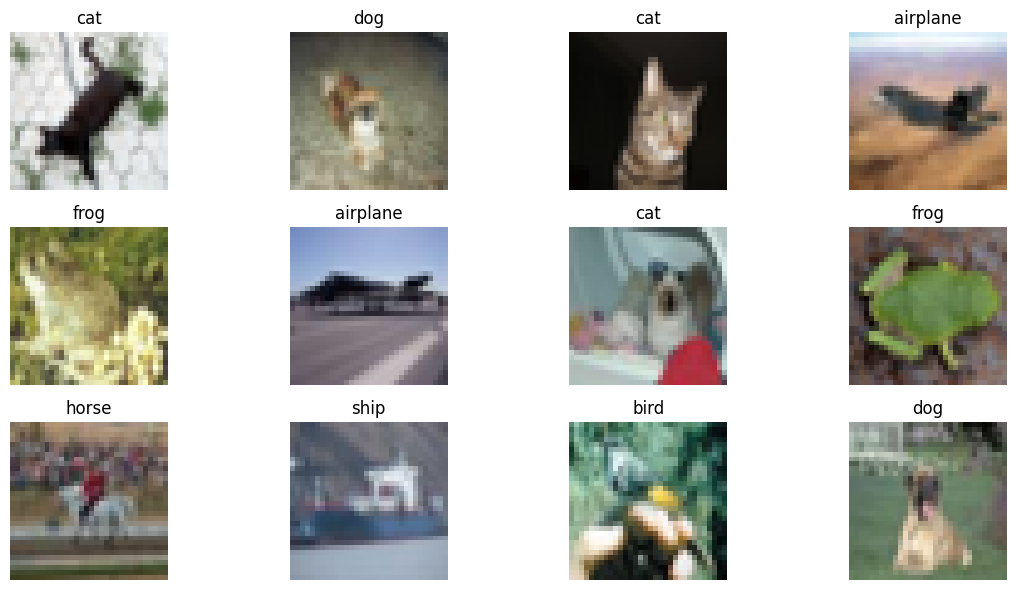

In [7]:
plt.figure(figsize=(12, 6))
for i in range(12):
  image = ds['train'][random.randint(0, len(ds['train']) - 1)]
  img_rgb = np.array(image['img'])

  plt.subplot(3, 4, i + 1)
  plt.title(id2label[image['label']])
  plt.imshow(img_rgb)
  plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
class PytorchImageFormat(Dataset):
  def __init__(self, hf_dataset, transform=None):
    self.dataset = hf_dataset
    self.transform = transform


  def __len__(self):
    return len(self.dataset)


  def __getitem__(self, index):
    image = self.dataset[index]['img']
    label = self.dataset[index]['label']

    if self.transform:
      image = self.transform(image)


    return image, label

In [10]:
train_ds = PytorchImageFormat(ds['train'], transform=transform)
train_ds

In [11]:
test_ds = PytorchImageFormat(ds['test'], transform=transform)
test_ds

In [12]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

In [38]:
class CNN(nn.Module):
  def __init__(self, num_classes=10):
    super(CNN, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.3),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.3)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(64 * 8 * 8, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes)
    )


  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x


model = CNN(num_classes=10)

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=4096, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [41]:
num_epoch = 10
train_losses = []
val_losses = []


for epoch in range(num_epoch):
  model.train()
  running_loss=0.0


  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()


  average_loss = running_loss / len(train_loader)
  train_losses.append(average_loss)


  model.eval()
  running_val_loss = 0.0

  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      running_val_loss += loss.item()


  avg_val_loss = running_val_loss / len(test_loader)
  val_losses.append(avg_val_loss)


  print(f'Epoch [{epoch+1}/ {num_epoch} | Train Loss: {average_loss:.4f}] | Val Loss: {avg_val_loss:.4f}')

Epoch [1/ 10 | Train Loss: 1.4689] | Val Loss: 1.2160
Epoch [2/ 10 | Train Loss: 1.2025] | Val Loss: 1.0330
Epoch [3/ 10 | Train Loss: 1.1087] | Val Loss: 0.9474
Epoch [4/ 10 | Train Loss: 1.0459] | Val Loss: 0.9220
Epoch [5/ 10 | Train Loss: 0.9996] | Val Loss: 0.8947
Epoch [6/ 10 | Train Loss: 0.9715] | Val Loss: 0.8741
Epoch [7/ 10 | Train Loss: 0.9428] | Val Loss: 0.8299
Epoch [8/ 10 | Train Loss: 0.9203] | Val Loss: 0.8222
Epoch [9/ 10 | Train Loss: 0.8950] | Val Loss: 0.8055
Epoch [10/ 10 | Train Loss: 0.8815] | Val Loss: 0.8152


In [42]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total = 0
    correct = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total

    return accuracy

In [43]:
val_acc = evaluate(model, test_loader, criterion, device)
print(f"Accuracy: {val_acc:.2f}%")

Accuracy: 71.98%


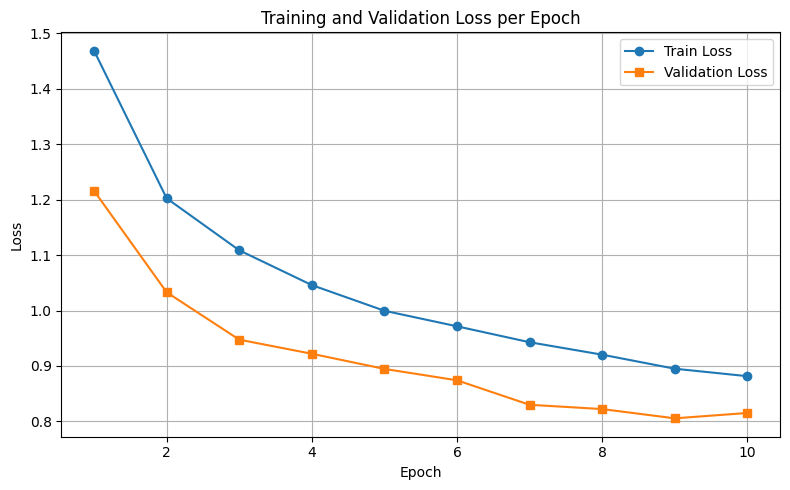

In [44]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epoch + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epoch + 1), val_losses, label='Validation Loss', marker='s')
plt.title("Training and Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()